<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/2201125_exp7_portrait_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step1. 인물 모드 직접 해 보기

## 최소 3장 이상의 인물모드 사진을 만들기

## Blur 외에 배경 사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도 

In [1]:
!mkdir -p ~/aiffel/human_segmentation/models
!mkdir -p ~/aiffel/human_segmentation/images

In [2]:
# 사진 준비
# !pip install pixellib

import os
import urllib # 웹에서 데이터를 다운로드 할때 사용
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
 # 시맨틱 세그멘테이션을 편하게 사용할수 있는 라이브러리
from matplotlib import pyplot as plt


(1280, 960, 3)


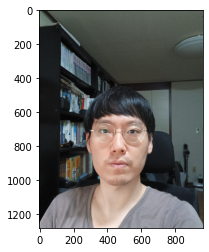

In [3]:
# 이미지 read 후 보내기

img_path = os.getenv("HOME") + '/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.show()

In [4]:
# 세그멘테이션으로 사람 분리

In [5]:
# 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

In [6]:
model_dir = os.getenv("HOME")+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/root/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa1f13ed90>)

In [8]:
# 그 다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [9]:
# module 'PIL.TiffTags' has no attribute 'IFD' 이 에러가 발생하면 위에서 # !pip install pixellib 
# 설치후에 restart runtime하고 다시 진행해야된다.

segvalues, output = model.segmentAsPascalvoc(img_path)

In [10]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# background를 제외하면 20개의 클래스가 있는데, 15를 가진 영역만 검출해낸다.
len(LABEL_NAMES)

21

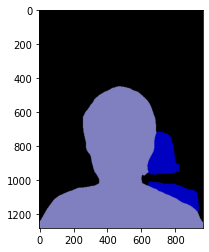

In [11]:
plt.imshow(output)
plt.show()

In [12]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [13]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [14]:
# PixelLib에서 그대로 가져온 코드

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
# 사람을 나태는 15번째 색상은?
colormap[15]

array([192, 128, 128])

In [16]:
# BGR을 RGB로 변환
seg_color = (128,128,192)

(1280, 960)


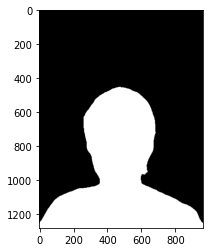

In [17]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

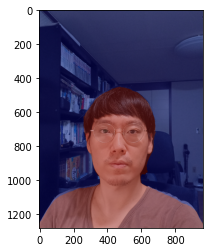

In [18]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

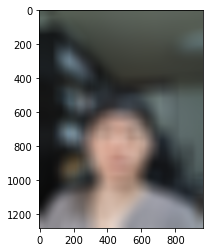

In [19]:
# 셀로우 포커스 만들기 -> 배경 흐리기

# 바꿔 보기!

img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

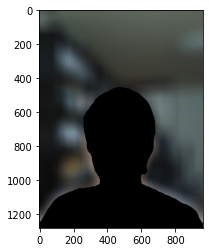

In [20]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출.

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

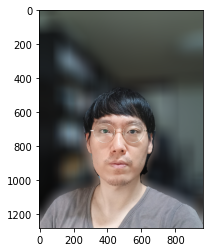

In [21]:
# 7-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(506, 550, 3)


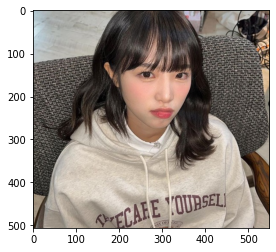

In [22]:
# 다른 인물로 적용
# 연예인 최예나 이미지로 적용을 해보자

# 이미지 read후 보내기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/choi.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.show()

In [24]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/root/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa1b2decd0>)

In [25]:
# 그 다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [26]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

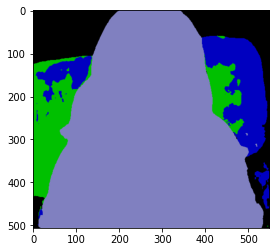

In [28]:
plt.imshow(output)
plt.show()

In [29]:
segvalues

{'class_ids': array([ 0,  9, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [30]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    # 뒤쪽에 sofa도 detection이 된다.

background
chair
person
sofa


In [31]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [32]:
colormap[15]

array([192, 128, 128])

In [33]:
seg_color = (128,128,192) # RGB로 변환

(506, 550)


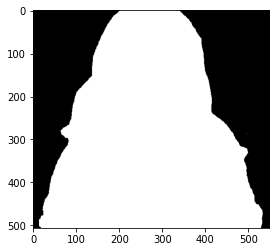

In [34]:
# seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

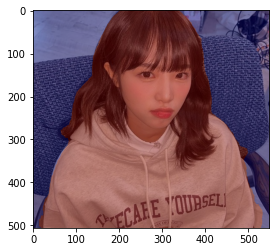

In [35]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿈
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합친다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

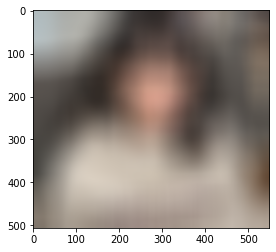

In [36]:
# 배경 Blur 하게 바꿔 보기!

img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

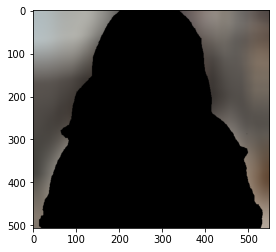

In [37]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

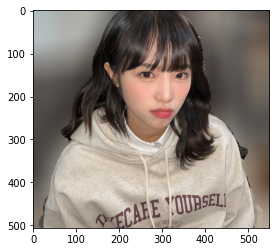

In [38]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Step2 에서 언급할테지만, 연예인 사진 같은 경우 오른쪽 옆에 어깨쪽 부분의 소파부분 그리고 머리 부분에서 정확한 세그멘테이션이 이루어지지 않음 

(960, 1280, 3)


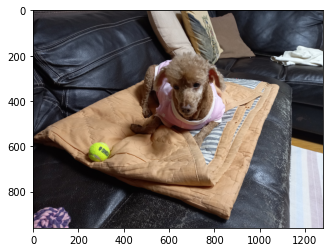

In [93]:
# 고양이 사진 대신에 집에서 키우는 강아지 사진으로 제작 (사람에서 동물로 객체변경!)

# 이미지 read 후 보내기

img_path = os.getenv("HOME") + '/aiffel/human_segmentation/images/dog.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.show()

In [94]:
# 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기 -> 사람 대신 강아지 분리

In [95]:
model_dir = os.getenv("HOME")+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/root/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa1b0572d0>)

In [96]:
# 그 다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성한다.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [97]:
# 이제 모델에 이미지를 입력
# module 'PIL.TiffTags' has no attribute 'IFD' 이 에러가 발생하면 위에서 # !pip install pixellib 
# 설치후에 restart runtime하고 다시 진행해야된다.

segvalues, output = model.segmentAsPascalvoc(img_path)

In [98]:
# PASCAL VOC로 학습된 label
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

21

In [99]:
# background를 제외하면 20개의 클래스가 있는데, 15를 가진 영역만 검출해낸다.


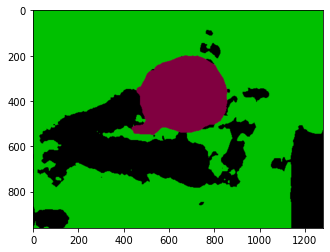

In [100]:
plt.imshow(output)
plt.show()

In [101]:
segvalues

{'class_ids': array([ 0, 12, 18]),
 'masks': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [102]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog
sofa


In [103]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [104]:
# 강아지를 나태는 12번째 색상은?
colormap[12]

array([ 64,   0, 128])

In [105]:
# BGR을 RGB로 변환
seg_color = (128,0,64)

(960, 1280)


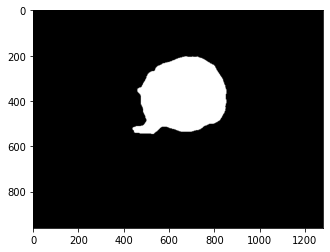

In [106]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

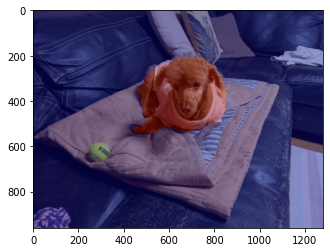

In [107]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

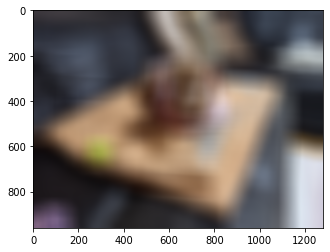

In [108]:
# 셀로우 포커스 만들기 -> 배경 흐리기

# 바꿔 보기!

img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

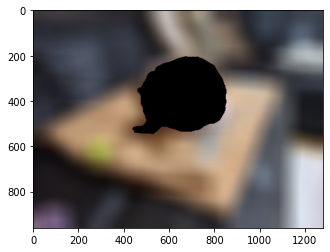

In [109]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출.

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

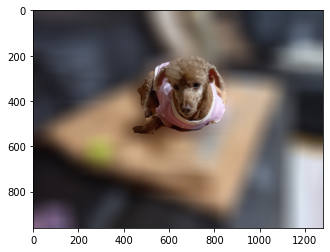

In [110]:
# 7-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

우리집 강아지 사진에서는 개로 특정하기는 하였으나 경계를 불분명하게 잡아서 실패를 하였다. 

특히 우리 똘이의 왼쪽 앞발을 지켜주지 못하였다 지못미ㅠ

웹에서 다른 사진을 가져와서 Test를 해보고 되지 않으면 cv2를 이용하여 다시 크로마 키 마스킹과 합성을 해보려고 한다.

(560, 560, 3)


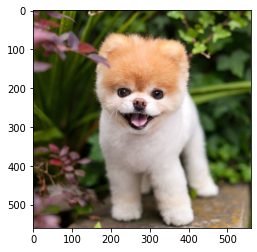

In [111]:
# 다른 강아지 이미지 read
img_path = os.getenv("HOME") + '/aiffel/human_segmentation/images/dog2.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.show()


In [112]:
model_dir = os.getenv("HOME")+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/root/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa1ba5ea10>)

In [113]:
# 그 다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [114]:
# 이제 모델에 이미지를 입력.
# module 'PIL.TiffTags' has no attribute 'IFD' 이 에러가 발생하면 위에서 # !pip install pixellib 
# 설치후에 restart runtime하고 다시 진행해야된다.

segvalues, output = model.segmentAsPascalvoc(img_path)

In [115]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# background를 제외하면 20개의 클래스가 있는데, 15를 가진 영역만 검출해낸다.
len(LABEL_NAMES)

21

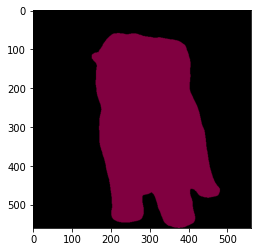

In [116]:
plt.imshow(output)
plt.show()

In [117]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [118]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

# 사진이 단순해서 그런지 배경이랑 강아지를 이전 우리강아지 사진보다 훨씬 정확하게 잡는다.

background
dog


In [119]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [120]:
# 사람을 나태는 12번째 색상은?
colormap[12]

array([ 64,   0, 128])

In [121]:
# BGR을 RGB로 변환
seg_color = (128,0,64)

(560, 560)


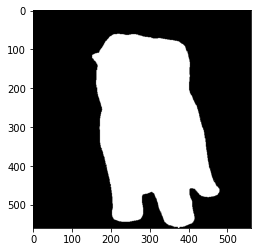

In [122]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

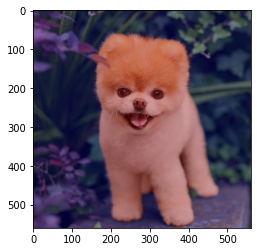

In [123]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

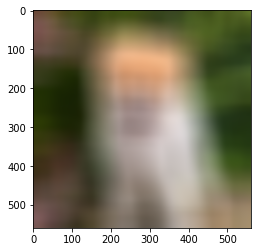

In [124]:
# 셀로우 포커스 만들기 -> 배경 흐리기

# 바꿔 보기!

img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

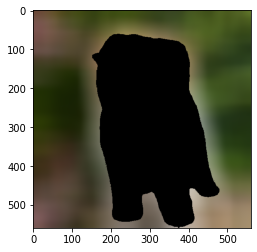

In [125]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출.

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

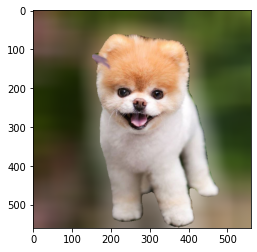

In [126]:
# 7-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성
# 배경영상과 객체영상 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

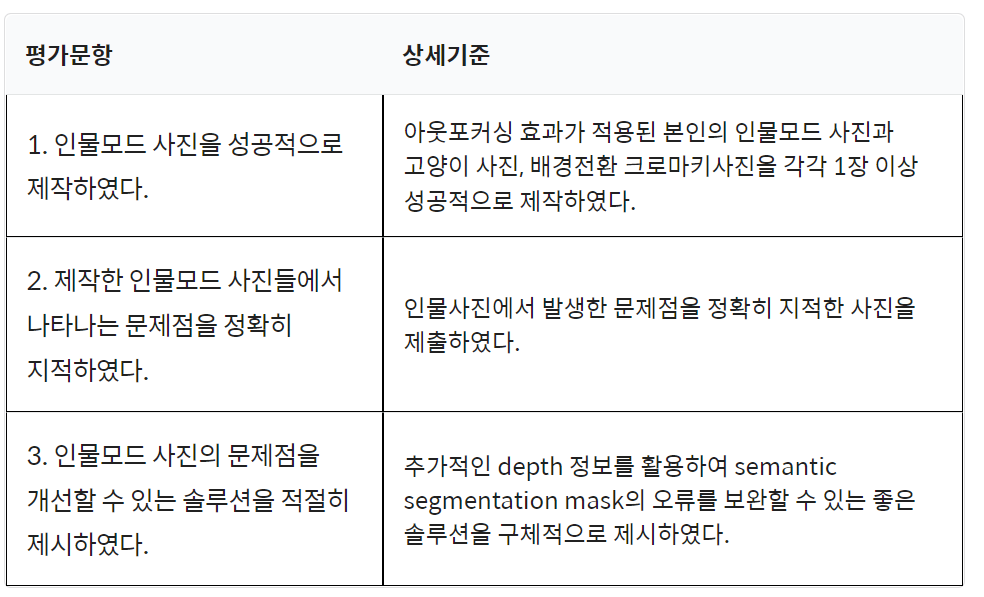

우선은 루브릭 문항 첫번째에서 2가지를 완성하였는데,
마지막 남은 배경전환 크로마키사진을 제작하여야 한다.

앞에서 언급되었듯이, 경계가 애매하게 잘리는 것은 3번째 평가문항에서 솔루션을 최종적으로 제시하여야 하는 문제이다.


# 그전에 앞서 비트와이즈 연산에 대해서 정리를 하고자 한다.

첫번째 평가문항의 배경 전환 크로마키사진을 제작하기 위해서는 필요한 부분이다.

Open Cv는 두 영상의 각 픽셀에 대한 비트와이즈(bitwise, 비트 단위) 연산 기능을 제공한다.
비트와이즈 연산은 두 영상을 합성할 때 특정 영역만 선택하거나 특정 영역만 제외하는 드으이 선별적인 연산에 도움이 된다. 
OpenCV에서 제공하는 비트와이즈 연산 함수는 다음과 같다.

1. bitwise_and(img1, img2, mask=None):
각 픽셀에 대해 비트와이즈 AND 연산
-> AND 연산은 교집합이라고 생각.

2. bitwise_or(img1, img2, mask=None):
각 픽셀에 대해 비트와이즈 OR 연산
-> OR 연산은 합집합이라고 생각.

3. bitwise_xor(img1, img2, mask=None):
각 픽셀에 대해 브트와이즈 XOR 연산
-> XOR 연산은 교집합을 제외한 차집합들의 합이라고 생각

4. bitwise_not(img1, mask=None):
각 픽셀에 대해 비트와이즈 NOT 연산

img1, img2 : 연산 대상 영상, 동일한 shape
mask: 0이 아닌 픽셀만 연산, 바이너리 이미지


## 배경전환 크로마키 사진 만들기

### 방법은 두가지가 있다.

##1. 위에서 진행하였던 Blur 하게 하는 code에서

##cv2.add를 사용하여 add() 함수를 이용해본다.

- 원래 code

img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 2. HSV로 변환후에 마스크 생성 및 합성 방법

In [ ]:
# 1. cv2.add를 사용하여 합성
# 최예나의 사진으로 다시 진행

(506, 550, 3)


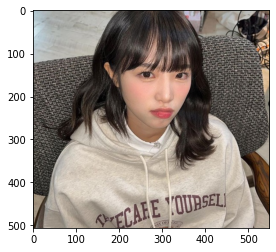

In [127]:
# 다른 인물로 적용
# 연예인 최예나 이미지로 적용을 해보자

# 이미지 read후 보내기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/choi.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.show()

In [128]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/root/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa1b382810>)

In [129]:
# 그 다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [130]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [131]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

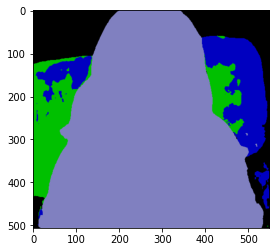

In [132]:
plt.imshow(output)
plt.show()

In [133]:
segvalues

{'class_ids': array([ 0,  9, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [134]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
sofa


In [135]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [136]:
colormap[15]

array([192, 128, 128])

In [137]:
seg_color = (128,128,192) # RGB로 변환

(506, 550)


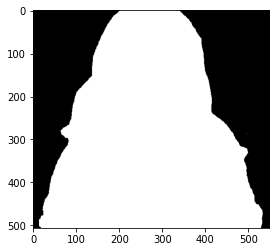

In [138]:
# seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

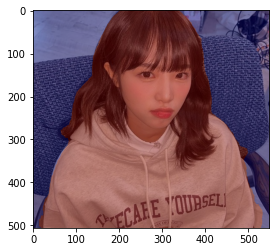

In [197]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿈
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합친다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

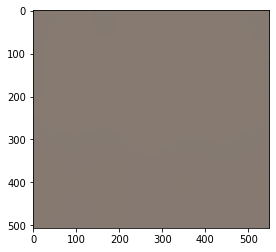

In [220]:
# 참고 블로그 : https://deep-learning-study.tistory.com/274, https://blog.naver.com/samsjang/220606250662
# https://velog.io/@jaehyeong/OpenCV%EB%A5%BC-%ED%99%9C%EC%9A%A9%ED%95%9C-%EA%B8%B0%EC%B4%88-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%B2%98%EB%A6%AC-with-Python
# 배경 투명하게 바꿔 보기! (배경 제거!)
# cv2.addWeighted(이미지1, 이미지1의 비율, 이미지2, 이미지2의 비율, 가중치)

# bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
# alpha = src[:,:,3] # Channel 3
# result = np.dstack([bgr, alpha]) # Add the alpha channel

# cv2.imwrite('51IgH_result.png', result)


img_orig_blur = cv2.blur(img_orig, (10000,10000))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

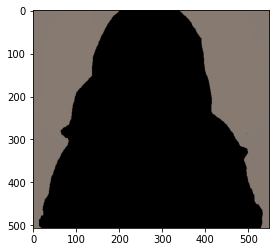

In [207]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

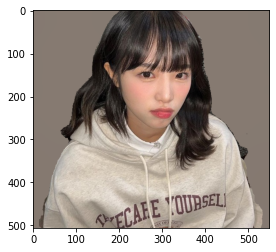

In [248]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite('yena.png', img_concat)
plt.show()

(1448, 2042, 3)


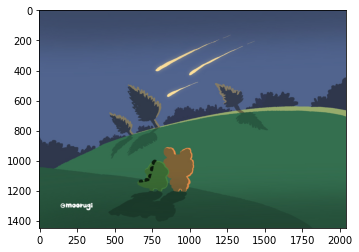

In [209]:
# Background 이미지 불러오기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background2.png'  
img_background = cv2.imread(img_path) 

print(img_background.shape)
plt.imshow(cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.show()

In [210]:
# add 함수 사용!

img_orig_add = cv2.add(img_orig, img_background)  
plt.imshow(cv2.cvtColor(img_orig_add, cv2.COLOR_BGR2RGB))
plt.show()

error: ignored


**역시 예상한 결과대로 단순한 add()함수로는 무리였다.**

이미지의 사이즈가 맞지 않아서 인데,

이는 numpy로 이미지를 다듬어서 사이즈를 맞게 ( 즉, 매트릭스 배열이 맞게) 해주는 방식을 쓰거나, 이미지 편집 프로그램으로 
해상도를 완전히 맞추어서 해주는 방식으로 진행하여야 한다.

2가지를 시도해보는 것도 좋으나, 역시 시간상의 문제로 사이즈와 상관없이 바로 할수 있는 방법을 사용하도록 하겠다.



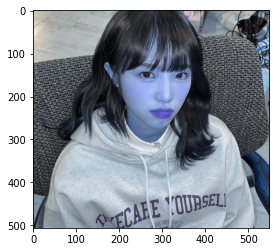

In [250]:
# 단일 배경색일때의 배경 이미지 삭제

import cv2
import numpy as np

# 이미지 불러오기 + Background 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/choi.png'  
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/background2.png'  

img_orig = cv2.imread(img_path) # 예나 사진 불러오기
img_background = cv2.imread(img_path2) # 배경 이미지 불러오기

# 변환 graky
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

# 임계값 조절
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# mask
mask = 255 - mask

# morphology 적용
# borderconstant 사용
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img_orig.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# 저장
cv2.imwrite('translated.png', result)
plt.imshow(result)

단일 색상일때의 배경 삭제라서 실패!

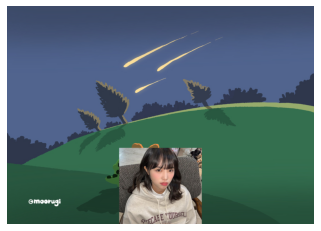

In [229]:
## 2. HSV로 변환후에 마스크 생성 및 합성 방법

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 불러오기 + Background 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/choi.png'  
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/background2.png'  

img_orig = cv2.imread(img_path) # 예나 사진 불러오기
img_background = cv2.imread(img_path2) # 배경 이미지 불러오기

# print(img_orig.shape)
# print(img_background.shape)
# plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
# plt.show()

# ROI(관심있는 부분) 선택을 위한 좌표 계산
height1, width1 = img_orig.shape[:2]
height2, width2 = img_background.shape[:2]
x = (width2 - width1)//2
y = height2 - height1
w = x + width1
h = y + height1

# 크로마키 배경 영상에서 크로마키 영역을 10픽셀 정도로 지정
chromakey = img_orig[:10, :10, :]
offset = 20

# 크로마키 영역과 영상 전체를 HSV로 변경
hsv_chroma = cv2.cvtColor(chromakey, cv2.COLOR_BGR2HSV)
hsv_img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2HSV)

# 크로마키 영역의 H값에서 offset 만큼 여유를 두어서 범위 지정
# offset 값은 여러차례 시도 후 결정
#chroma_h = hsv_chroma[0]
chroma_h = hsv_chroma[:,:,0]
lower = np.array([chroma_h.min()-offset, 100, 100])
upper = np.array([chroma_h.max()+offset, 255, 255])

# 마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img, lower, upper)
mask_inv = cv2.bitwise_not(mask)
roi = img_background[y:h, x:w]
fg = cv2.bitwise_and(img_orig, img_orig, mask=mask_inv)
bg = cv2.bitwise_and(roi, roi, mask=mask)
img_background[y:h, x:w] = fg + bg

# cv2.addWeighted(이미지1, 이미지1의 비율, 이미지2, 이미지2의 비율, 가중치)
# addWeight = cv2.addWeighted(img_orig,1.0, img_background, 0.0, 0)

# 결과 출력
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.imshow(cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB)) 
plt.axis('off') # 축 숨기기 (x, y축)
plt.show('chromakey', img_orig)
plt.show('added', img_background)
# plt.show('trans', addWeight)

합성은 어찌저찌 됐으나 실패!

(-0.5, 2041.5, 1447.5, -0.5)

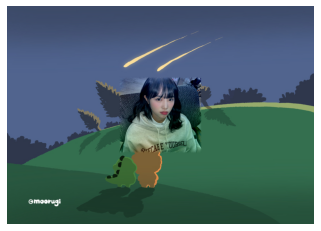

In [239]:
## 2. HSV로 변환후에 마스크 생성 및 합성 방법

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 불러오기 + Background 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/choi.png'  
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/background2.png'  

img_orig = cv2.imread(img_path) # 예나 사진 불러오기
img_background = cv2.imread(img_path2) # 배경 이미지 불러오기

# 마스크 생성, 합성할 이미지 전체 영역을 255로 세팅
mask = np.full_like(img_orig, 255)

# 합성 대상 좌표 계산 
height, width = img_background.shape[:2]
center = (width//2, height//2)

# seamlessClone ()함수로 합성
mixed = cv2.seamlessClone(img_orig, img_background, mask, center, cv2.MIXED_CLONE)
normal = cv2.seamlessClone(img_orig, img_background, mask, center, cv2.NORMAL_CLONE)

# 결과 출력
# plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR로 기본 세팅되어 있는 cv2를 RGB로 변경
plt.imshow(cv2.cvtColor(mixed, cv2.COLOR_BGR2RGB)) 
plt.imshow(cv2.cvtColor(normal, cv2.COLOR_BGR2RGB)) 


plt.axis('off') # 축 숨기기 (x, y축)
# plt.show('chromakey', img_orig)
# plt.show('added', img_background)

## 역시투명하지 않아서 실패 -> 뒷 배경에서의 언덕에서의 경계부분에서 색상이 나눠지기 때문에 가장 center에 최예나의 사진을 두어 SeamlessClone() 함수의 working을 보았는데, 배경에 맞게 사진의 색상이 변화하기는 하지만, 완벽하게 투명한 상태로 되어 두 사진이 동화되어 이질감 없이 합성하는 것은 되지 않았다.

여러 가지 시도를 해보았으나, 인터넷 서치상에서도 투명하게 하는 방법들이 나와있었고 함수들도 있었으나, 명쾌한 답이 없었고 최종적으로 내린 결론은 메뉴얼대로 직접 좌표를 계산하여 코드를 하나하나씩 짜서 제거 하는 방법밖에 없었다.

현재 넘파이에도 익숙하지 않아서 메뉴얼이 힘든 상황인데, 
이를 대체하기 위해서 여러가지 방ㅇ법들을 다 찾아 보았으나

cv2.bgsegm.createBackgroundSubtractorMOG 같은 경우에는 움직이는 영상에서 배경을 투명하게 하는 방법이었고(사진이 아님!),
RGB에서 alpha 채널을 추가하여 투명도를 조정하는 방법도 실패

최종적으로 나온 함수중에 cv2.SeamlessClone()함수로 자동화하여 합성된 이미지와 배경을 맞추어주는 기능이 있는 함수였지만, 위에서 보다시피 완전하게 투명하게는 못 만들었다.

왜 blur와 같이 편리성이 있도록 배경을 투명하게 만드는 기능이 없는지는 의문이 들었고, 하다하다가 3시간이 지나가 버렸다.



# STEP 2

사진들에서 나타나는 문제점을 지적하는 부분은 충분히 할수 있었다.


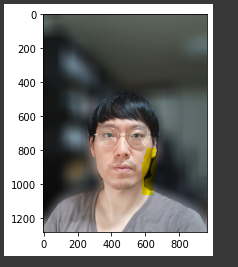

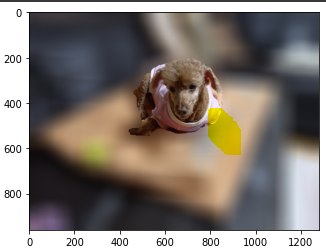

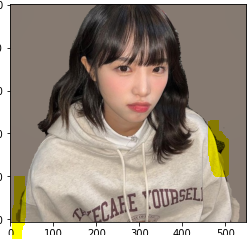

보다시피 경계를 정확히 잡지 못하여 사람같은 경우에는 옷이나 목 부분에서의 경계 침범이 발생 그리고 우리집 강아지 같은 경우에는 왼쪽 앞발의 결손으로 나타나게 되었다. 

# STEP 3 해결 방안을 제시

익스플로레이션에서 힌트로 제시된 부분들은 3D 이미징 기술, 소프트웨어 기술 활용(구글의 struct2Depth), IR (적외선) 카메라 등이 제시가 되었는데 이과출신이지만, 정통 공돌이 출신이 아닌 나로서는 극복할수 있는 방법은 하드웨어적인 기술의 추가에서는 더 이상의 개선책을 제시할수가 없었다.

특히 3D 이미징 기술이라던지, IR 카메라 같은 경우에는 반도체의 개념과 그리고 물리에서의 광학개념이 들어가는 부분이라서 하드웨어적으로 input한 데이터를 가지고 다듬어야하는 소프트웨어적인 측면에서의 접근은 향후 가능할지 모르나, 더 심도있게는 생각할 수가 없었다.

https://seoftware.tistory.com/185

https://go-hard.tistory.com/119

위와 같은 티스토리 자료들은 논문의 리뷰들인데, CNN에서의 개선을 위해서 딥러닝 프레임 워크 자체를 바닥부터 뜯어서 개선책을 제시하고 있었다.

현재 CNN의 기본적인 특징과 model을 겨우 만들어서 실습하는 입장에서 이러한 전문적인 설계도면을 짜는 것은 나중에나 가능하지 않을까 라는 생각이 들었다.

더 추가적으로 찾아보니 딥러닝에서는 특히, segmentation에서의 만족스럽게 매끈한 가공을 하는 것은 불가능하고 (왜냐하면 데이터셋의 단위가 몇만단위로 가버리면 그걸 어떻게 하나하나 가공을 하여서 학습을 시키느냐의 문제에 직면하게 되므로, 현실적인 타협으로 어느정도 경계가 구별된 사진을 사용할수 밖에 없다.) 

현재 책이나 인터넷에서 소개된 방식들(FCN, SegNEt, U-Net 그리고 DeepLab v3+)로의 접근이 최선이고 이러한 기술또한 완벽하게 100프로 만족스러운 성능이 아니기에 지금도 계속 논문이 나오고 연구가 이루어지는 것이 아닌가 싶다.

## 이번 익스에서는 배경을 투명하게 하는 것을 완벽하게 못해 너무나도 아쉬운만큼 제출기간이 지나더라도 꼭 질의를 해서 해결을 해봐야겠다.
